## Multi label image classification

Multi label classification refers to when each training instance has more than one class or label.

## Importing Libraries

In [0]:
%reload_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%matplotlib inline

# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from fastai.vision import *

## Downloading dataset from Kaggle

In [0]:
path = Path('drive/My Drive/fast.ai')

In [92]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Jul  9 03:59 .
drwxr-xr-x 1 root root 4096 Jul  9 03:58 ..
drwxr-xr-x 1 root root 4096 Jul  3 16:14 .config
drwx------ 3 root root 4096 Jul  9 03:59 drive
drwxr-xr-x 1 root root 4096 Jul  3 16:14 sample_data


Copy the uploaded `kaggle.json` which contains a unique API key to `~/.kaggle`

In [0]:
! mkdir -p ~/.kaggle/
! cp drive/'My Drive'/fast.ai/kaggle.json ~/.kaggle/

In [93]:
! ls -al ~/

total 76
drwx------ 1 root root 4096 Jul  9 09:51 .
drwxr-xr-x 1 root root 4096 Jul  9 03:58 ..
-rw------- 1 root root  751 Jul  9 03:59 .bash_history
-rw-r--r-- 1 root root 3106 Apr  9  2018 .bashrc
drwx------ 1 root root 4096 Jul  9 06:05 .cache
drwx------ 1 root root 4096 Jul  9 03:59 .config
drwxr-xr-x 3 root root 4096 Jul  3 16:15 .gsutil
drwxr-xr-x 1 root root 4096 Jul  3 16:51 .ipython
drwx------ 2 root root 4096 Jul  3 16:51 .jupyter
drwxr-xr-x 2 root root 4096 Jul  9 09:52 .kaggle
drwxr-xr-x 2 root root 4096 Jul  9 03:58 .keras
drwx------ 1 root root 4096 Jul  3 16:51 .local
drwxr-xr-x 3 root root 4096 Jul  3 16:51 .node-gyp
drwxr-xr-x 4 root root 4096 Jul  3 16:51 .npm
drwx------ 3 root root 4096 Jul  9 05:56 .nv
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile


In [0]:
!ls drive/'My Drive'/fast.ai/.kaggle

kaggle.json


Install kaggle for downloading the datasets required as follows,

In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.4)


In [0]:
path = path/'planet'
path

PosixPath('drive/My Drive/fast.ai/planet')

> Note :
* Accept competition rules in Kaggle before downloading the datasets.
* Put quotes around the paths e.g. `"{path}"` to be safe, since the path variable expands before execution and might have spaces.

Downloading the training dataset

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p "{path}"
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p "{path}"  
! unzip -q -n "{path}/train_v2.csv.zip" -d "{path}"

100% 600M/600M [00:07<00:00, 105MB/s]
100% 600M/600M [00:08<00:00, 78.5MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 19.1MB/s]


Downloading the test dataset

In [94]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p "{path}"

 99% 598M/603M [00:10<00:00, 60.2MB/s]
100% 603M/603M [00:10<00:00, 60.4MB/s]


Unzip `7z` and `tar` files as follows,

In [0]:
! sudo apt install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
!7z x -so "{path}/planet/train-jpg.tar.7z" | tar xf - -C "{path.as_posix()}"

Here in the planet dataset, each training instance has multiple labels 

In [95]:
df = pd.read_csv(path/'planet/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


## Creating a DataBunch


Notes :  
`Dataset` class from PyTorch is an abstract class.It contains,
* __getitem__ : objects can be indexed o[..]
* __len__ : len()

`torch.utils.data.DataLoader`

* Takes `Dataset` in its *constructor*

### Data Augmentation & Transformations


> Notes :
* Satellite images can be flipped vertically (not just horizontally)
* No perspective warping 

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, 
                      max_zoom=1.05, max_warp=0.)

### Creating a DataBunch

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path/'planet', 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
print(src)

LabelLists;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: drive/My Drive/fast.ai/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: drive/My Drive/fast.ai/planet;

Test: None


In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
data

ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: drive/My Drive/fast.ai/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: drive/My Drive/fast.ai/planet;

Test: None

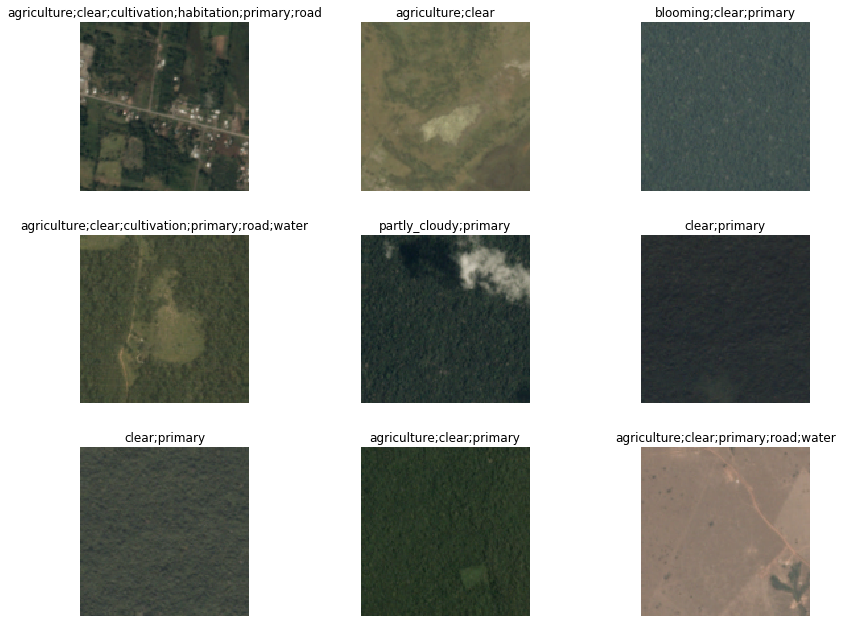

In [0]:
data.show_batch(rows=3, figsize=(12,9))

## Model building

Defining the architecture and key metrics

In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2) # the kaggle leaderboard used F2 for evaluation 

Creating a learner (model) as follows,

In [0]:
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [0]:
print(len(data.classes))
data.classes

17


['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

> Before training a learner (model) always use the `lr_finder()` to give a good estimate of an optimal learning rate. A constant learning rate could be used for all the layers or alternatively discriminative layer training could be used. For the first stage of training, a constant learning rate should be used (i.e. same lr for all the hidden layers).

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02
Min loss divided by 10: 3.02E-02


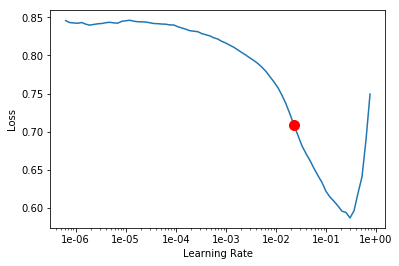

In [0]:
learn.recorder.plot(suggestion=True) # To get the steepest gradient in the curve

In [0]:
lr = 1e-02 # Selecting a lr which is ~10x less than the lowest point

In [0]:
learn.fit_one_cycle(5, slice(lr,2*lr)) # Use a single value preferably, at this stage

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.121974,0.109485,0.947593,0.904228,05:21
1,0.118723,0.112468,0.948719,0.901510,05:08
2,0.109833,0.099239,0.952425,0.914233,05:06
3,0.098617,0.091248,0.960164,0.922337,05:01
4,0.092172,0.104946,0.955281,0.925882,05:05


In [0]:
learn.save('stage-1-resnet50')

In [0]:
# For loading the model
# learn.load('stage-1-resnet50')

In [99]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

### Fine tuning

Now we unfreeze all the layers and make them trainable (i.e. internally sets the layers' `requires_grad` attribute to `True`)

In [0]:
learn.unfreeze()

> One approach would be to create a DataBunch with only the misclassified examples and train a bit more (with Discriminative layer training).

In [101]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 7.59E-08


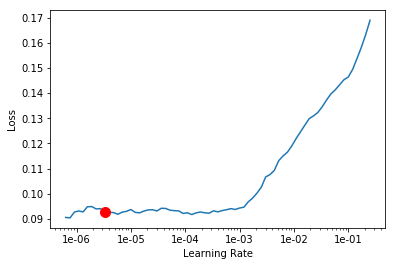

In [102]:
learn.recorder.plot(suggestion=True)

> Rule of thumb : 
1. For 1st part of the slice() choose a point 10x less than the point where the plot starts going up
2. For 2nd part : use lr/5 or lr/10
Here lr is the learning rate used for the frozen part.
* The suggested point should only be selected after taking the whole plot into account.

In [0]:
x = 5 # or 10

In [105]:
learn.fit_one_cycle(5, slice(1e-04, lr/x))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101230,0.116825,0.947433,0.915841,05:08
1,0.097826,0.106008,0.947651,0.915129,05:04
2,0.093937,0.130889,0.955920,0.924243,05:02
3,0.089579,0.118575,0.957163,0.927488,05:00
4,0.088840,0.107080,0.958122,0.927841,04:58


In [0]:
learn.save('stage-2-resnet50')

## Transfer learning from smaller image sizes to larger image sizes

Downsampled images can be used for quick experimentation.

>Question - How can we use a model trained on 128x128 pixel images for training 256x265 pixel images?


We can fine tune the pretrained model. 256x256 images would contain more information than its 128 counterparts.

### New DataBunch with 256x256 images

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data

In [109]:
data.train_ds[0]

(Image (3, 256, 256), MultiCategory haze;primary)

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.98E-03


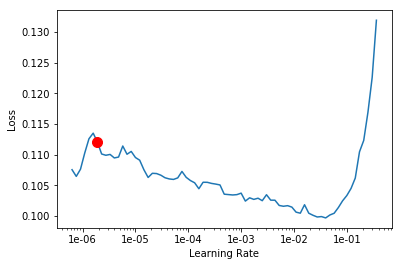

In [113]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-02

In [0]:
learn.fit_one_cycle(5, max_lr=slice(lr))

In [0]:
learn.save('stage-1-256-resnet50')

Similarly we can continue to train and fine tune the model,

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-05, lr/5))

In [0]:
learn.save('stage-1-256-resnet50')

## References

[1] https://course.fast.ai/videos/?lesson=3  
[2] https://pytorch.org/tutorials/beginner/data_loading_tutorial.html